In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pickle

In [9]:
dataset = qml.data.load("qchem", molname="He2", bondlength=5.2, basis="6-31G", 
                     attributes=["hamiltonian", "fci_spectrum", "fci_energy", "hf_state", "vqe_gates"])

In [10]:
class AnsatzGenerator:
    def __init__(self, num_qubits, hamiltonian, molecular_data):
        self.num_qubits = num_qubits
        self.hamiltonian = hamiltonian
        self.num_params_groundstate = 4*num_qubits
        self.num_params_excited = 4*(num_qubits-1)*2
        self.data = molecular_data

    def _ctrl_ansatz_gates(self, params):
        for i in range(self.num_qubits-1):
            qml.CRY(params[i], wires=[0, i+1])
            qml.CRZ(params[self.num_qubits - 1 + i], wires=[0, i+1])

        for i in range(1, self.num_qubits - 1):
            qml.Toffoli(wires=[0,i, i+1])

        for i in range(self.num_qubits-1):
            qml.CRY(params[2*(self.num_qubits - 1) + i], wires=[0, i+1])
            qml.CRZ(params[3*(self.num_qubits - 1) + i], wires=[0, i+1])

    def _ansatz_gates(self):
        """Define the gates for the hardware efficient ansatz"""
        qml.BasisState(self.data.hf_state, wires = range(num_qubits))
        for op in self.data.vqe_gates:
            qml.apply(op)

    def ansatz_groundstate(self):
        """Define the ansatz to compute the ground state"""
        self._ansatz_gates()
        return qml.expval(self.hamiltonian)


    def setGroundStateResultParams(self, result_params):
        self.result_params = result_params

    def ansatz_excited(self, params):
        """Define the ansatz to compute the excited state"""
        qml.adjoint(self._ansatz_gates)() 
    
        qml.PauliX(wires=0)
    
        self._ctrl_ansatz_gates(params[0:int(self.num_params_excited/2)])

        for i in range(1, self.num_qubits):
            qml.PauliX(wires=i)

        qml.MultiControlledX(control_wires=range(1, self.num_qubits), wires=0)

        for i in range(self.num_qubits):
            qml.PauliX(wires=i)

        self._ctrl_ansatz_gates(params[int(self.num_params_excited/2):])
        self._ansatz_gates()
        return qml.expval(self.hamiltonian)

In [11]:
num_qubits = len(dataset[0].hf_state)
H = dataset[0].hamiltonian
dev = qml.device('default.qubit', wires=num_qubits)
ansatzGenerator = AnsatzGenerator(num_qubits, H, dataset[0])

ansatz_groundstate = qml.QNode(ansatzGenerator.ansatz_groundstate, dev)

In [12]:
ansatz_groundstate()

tensor(-5.74002344, requires_grad=True)

In [13]:
np.sort(dataset[0].fci_spectrum)

tensor([-5.74032428, -4.86378042, -4.86378042, -4.86377941, -4.86377941,
        -4.36548973, -4.36548973, -4.3654816 , -4.3654816 , -4.26946994,
        -4.26946994, -4.26946994, -4.26946994, -4.26946994, -4.26946994,
        -3.88547091, -3.88547091, -3.88547091, -3.88547091, -3.81887502,
        -3.81887502, -3.59070594, -3.59070594, -3.59070594, -3.59070594,
        -3.59070594, -3.59070594, -3.59070594, -3.59070594, -3.39292979,
        -3.39292979, -3.39292979, -3.39292979, -3.39292768, -3.39292768,
        -3.39292346, -3.39292346, -3.39292135, -3.39292135, -3.39292135,
        -3.39292135, -2.94233242, -2.94233242, -2.9423289 , -2.9423289 ,
        -2.906315  , -2.906315  , -2.906315  , -2.906315  , -2.89463233,
        -2.89463233, -2.89463233, -2.89463233, -2.89463183, -2.89463183,
        -2.89463082, -2.89463082, -2.89463031, -2.89463031, -2.89463031,
        -2.89463031, -2.88888241, -2.88888241, -2.88888241, -2.88888241,
        -2.87016214, -2.87016214, -2.79861559, -2.7

In [14]:
class VQE:
    def __init__(self, num_params, ansatz):
        self.max_iterations = 1000
        self.conv_tol = 1e-06
        self.opt = qml.QNGOptimizer(0.01)
        self.num_params = num_params
        self.ansatz = ansatz

    def run(self):
        """Run the VQE. 
        Return the optimized parameters and the vector of energies that is computed during the optimization. 
        The last item in the vector is the lowest energy.
        """
        theta = np.random.random(self.num_params)
        energy = [self.ansatz(theta)]

        angle = [theta]
        

        for n in range(self.max_iterations):
            theta, prev_cost = self.opt.step_and_cost(self.ansatz, theta)
            energy.append(self.ansatz(theta))
            angle.append(theta)
            if n%10 == 0:
                print(f"Energy {n} = {energy[-1]}")
            conv = np.abs(energy[-1] - prev_cost)
            if conv <= self.conv_tol:
                break
        return angle[-1], energy
    
    def run_again(self, starting_param):
        theta = starting_param
        energy = [self.ansatz(theta)]

        angle = [theta]
        

        for n in range(self.max_iterations):
            theta, prev_cost = self.opt.step_and_cost(self.ansatz, theta)
            energy.append(self.ansatz(theta))
            angle.append(theta)
            if n%10 == 0:
                print(f"Energy {n} = {energy[-1]}")
            conv = np.abs(energy[-1] - prev_cost)
            if conv <= self.conv_tol:
                break
        return angle[-1], energy

In [16]:
ansatz_excited = qml.QNode(ansatzGenerator.ansatz_excited, dev)
vqe = VQE(ansatzGenerator.num_params_excited, ansatz_excited)
params_excited, energies_excited = vqe.run()



Energy 0 = -0.3580687023841098
Energy 10 = -2.3401927996585496
Energy 20 = -3.333730023760318
Energy 30 = -3.92153220113534
Energy 40 = -4.4490712840678714
Energy 50 = -4.692184965872462
Energy 60 = -4.762095158616
Energy 70 = -4.783864003070389
Energy 80 = -4.793368026842501
Energy 90 = -4.798728025748056
Energy 100 = -4.802096509641774
Energy 110 = -4.804287564137834
Energy 120 = -4.805726291549071
Energy 130 = -4.8066730486963944
Energy 140 = -4.807296191690976
Energy 150 = -4.807706243935833
Energy 160 = -4.807976005242747
Energy 170 = -4.80815343764986
Energy 180 = -4.8082701252115845
Energy 190 = -4.808346856818109
Energy 200 = -4.808397310869898
Energy 210 = -4.8084304849801365
Energy 220 = -4.808452296719358
Energy 230 = -4.8084666375154645


NameError: name 'energies_excited_He2' is not defined

In [17]:
with open('energies_excited_He2_QNG.pickle', 'wb') as handle:
    pickle.dump(energies_excited, handle)
    
with open('params_excited_He2_QNG.pickle', 'wb') as handle:
    pickle.dump(params_excited, handle)

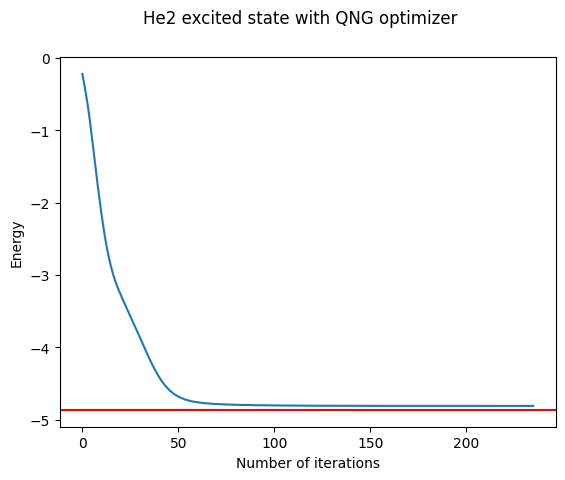

In [22]:
excited = np.sort(dataset[0].fci_spectrum)[1]
plt.axhline(y=excited, color='r', linestyle='-')
plt.plot(range(len(energies_excited)), energies_excited)
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.suptitle("He2 excited state with QNG optimizer")
plt.savefig("He2_excited_QNG.png")
plt.show()

In [21]:
-4.86378042 + 4.8084666375154645

-0.05531378248453578